In [1]:
!pip install medmnist

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import medmnist
from medmnist import INFO, Evaluator

In [3]:
data = 'nodulemnist3d'
download_flag = True

informations = INFO[data]
DataClass = getattr(medmnist, informations['python_class'])

train_ds = DataClass(split='train', download=download_flag)
test_ds = DataClass(split='test', download=download_flag)
informations   

Using downloaded and verified file: /home/dingo/.medmnist/nodulemnist3d.npz
Using downloaded and verified file: /home/dingo/.medmnist/nodulemnist3d.npz


{'python_class': 'NoduleMNIST3D',
 'description': 'The NoduleMNIST3D is based on the LIDC-IDRI, a large public lung nodule dataset, containing images from thoracic CT scans. The dataset is designed for both lung nodule segmentation and 5-level malignancy classification task. To perform binary classification, we categorize cases with malignancy level 1/2 into negative class and 4/5 into positive class, ignoring the cases with malignancy level 3. We split the source dataset with a ratio of 7:1:2 into training, validation and test set, and center-crop the spatially normalized images (with a spacing of 1mm×1mm×1mm) into 28×28×28.',
 'url': 'https://zenodo.org/record/6496656/files/nodulemnist3d.npz?download=1',
 'MD5': '8755a7e9e05a4d9ce80a24c3e7a256f3',
 'task': 'binary-class',
 'label': {'0': 'benign', '1': 'malignant'},
 'n_channels': 1,
 'n_samples': {'train': 1158, 'val': 165, 'test': 310},
 'license': 'CC BY 4.0'}

In [4]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as opt
from torch.utils.data import DataLoader
import torchvision.transforms as tt



In [5]:
train_dl = DataLoader(dataset=train_ds, batch_size=128, shuffle=True)
test_dl = DataLoader(dataset=test_ds, batch_size=128)

In [6]:
x, y = train_ds[0]
x.shape, y.shape, len(train_ds)

((1, 28, 28, 28), (1,), 1158)

In [7]:
for X, y in train_dl:
    print(X.shape, y.shape)
    

torch.Size([128, 1, 28, 28, 28]) torch.Size([128, 1])
torch.Size([128, 1, 28, 28, 28]) torch.Size([128, 1])
torch.Size([128, 1, 28, 28, 28]) torch.Size([128, 1])
torch.Size([128, 1, 28, 28, 28]) torch.Size([128, 1])
torch.Size([128, 1, 28, 28, 28]) torch.Size([128, 1])
torch.Size([128, 1, 28, 28, 28]) torch.Size([128, 1])
torch.Size([128, 1, 28, 28, 28]) torch.Size([128, 1])
torch.Size([128, 1, 28, 28, 28]) torch.Size([128, 1])
torch.Size([128, 1, 28, 28, 28]) torch.Size([128, 1])
torch.Size([6, 1, 28, 28, 28]) torch.Size([6, 1])


In [8]:
img = train_ds.montage(length=30, save_folder='img/')

/home/dingo/.local/lib/python3.10/site-packages/medmnist/utils.py:25: FutureWarning: `multichannel` is a deprecated argument name for `montage`. It will be removed in version 1.0. Please use `channel_axis` instead.
  montage_arr = skimage_montage(sel_img, multichannel=(n_channels == 3))


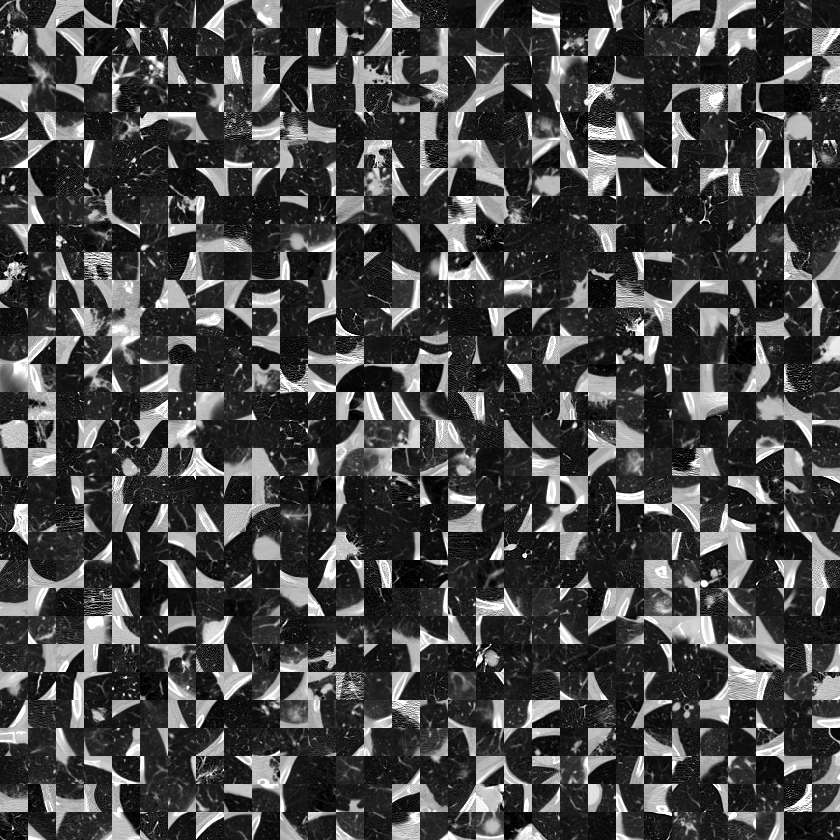

In [9]:
img[5]

In [10]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        self.conv_layer1 = self._conv_layer_set(1, 32)
        self.conv_layer2 = self._conv_layer_set(32, 64)
        self.fc1 = nn.Linear(8000, 128)
        self.fc2 = nn.Linear(128, 1)
        self.relu = nn.LeakyReLU()
        self.batch=nn.BatchNorm1d(128)
        self.drop=nn.Dropout(p=0.15)        
        
    def _conv_layer_set(self, in_c, out_c):
        conv_layer = nn.Sequential(
        nn.Conv3d(in_c, out_c, kernel_size=(3, 3, 3), padding=0),
        nn.LeakyReLU(),
        nn.MaxPool3d((2, 2, 2)),
        )
        return conv_layer
    

    def forward(self, x):
        out = self.conv_layer1(x)
        out = self.conv_layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.batch(out)
        out = self.drop(out)
        out = self.fc2(out)
        
        return out



In [13]:
model = CNNModel()
model.double()
loss_func = nn.BCEWithLogitsLoss()
optimizer = opt.Adam(model.parameters(), lr=0.001)

In [14]:
for epoch in range(10):
    train_correct = 0
    train_total = 0
    test_correct = 0
    test_total = 0
    
    model.train()
    for inputs, targets in tqdm(train_dl):
        inputs.type(torch.double)
        print(inputs.dtype)
        optimizer.zero_grad()
        outputs = model(inputs.double())
        targets = targets.double()
        loss = loss_func(outputs, targets)
        
        loss.backward()
        optimizer.step()

  0%|          | 0/10 [00:00<?, ?it/s]

torch.float64


 10%|█         | 1/10 [00:05<00:47,  5.25s/it]

torch.float64


 20%|██        | 2/10 [00:08<00:32,  4.09s/it]

torch.float64


 30%|███       | 3/10 [00:11<00:26,  3.79s/it]

torch.float64


 40%|████      | 4/10 [00:15<00:21,  3.62s/it]

torch.float64


 40%|████      | 4/10 [00:18<00:27,  4.65s/it]


KeyboardInterrupt: 

In [ ]:
def test(split):
    model.eval()
    y_true = torch.tensor([])
    y_score = torch.tensor([])
    
    data_loader = train_loader_at_eval if split == 'train' else test_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model(inputs)

            targets = targets.squeeze().long()
            outputs = outputs.softmax(dim=-1)
            targets = targets.float().resize_(len(targets), 1)

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.numpy()
        y_score = y_score.detach().numpy()
        
        evaluator = Evaluator(data, split)
        metrics = evaluator.evaluate(y_score)
    
        print('%s  auc: %.3f  acc:%.3f' % (split, *metrics))

        
print('==> Evaluating ...')
test('train')
test('test')